In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

train = pd.read_csv ('data_titanic/titanic_train_wrangled.csv')
test = pd.read_csv ('data_titanic/titanic_test_wrangled.csv')

In [2]:
# remove unused columns
exclude = ['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 
            'parch', 'ticket', 'fare', 'cabin', 'embarked', 'title', 'age_cat', 'fare_cat',
            'cabin_type']
feature_candidates = train.drop (columns=exclude).drop (columns=['survived'])
feature_names = list (feature_candidates.columns)
test = test.drop (columns=exclude)

In [3]:
# which features are the most useful
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression ()
lr.fit (feature_candidates, train['survived'])
lr.coef_[0]
corr = pd.Series (lr.coef_[0], index=feature_names)
corr_sorted = corr.abs().sort_values(ascending=False)
feature_names_final = list(corr_sorted.index)[:30]
features = train[feature_names_final]
target = train['survived']

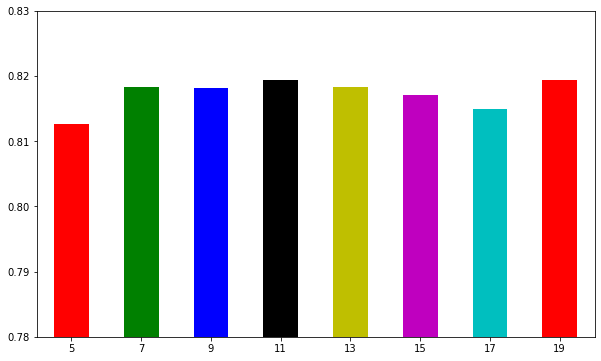

In [4]:
"""
    Linear Regression
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model_scores = {}
for val in range(5,20,2):
    lr = LogisticRegression()
    accuracy = cross_val_score (lr, features, target, cv=val)
    model_scores[val] = accuracy.mean()

pd.Series(model_scores).plot.bar(figsize=(10,6), ylim=(0.78,0.83), color=list('rgbkymc'), rot=0)

In [5]:
max (model_scores.values())

0.8193923754807927

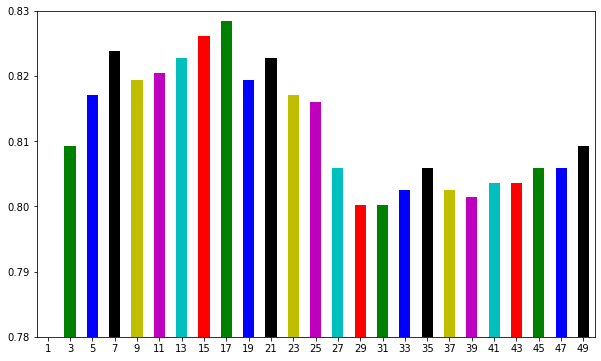

In [6]:
"""
    K-Nearest Neighbors
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

model_scores = {}
for val in range(1,50,2):
    knn = KNeighborsClassifier (n_neighbors=val)
    accuracy = cross_val_score (knn, features, target, cv=10)
    model_scores[val] = accuracy.mean()


pd.Series(model_scores).plot.bar(figsize=(10,6), ylim=(0.78,0.83), color=list('rgbkymc'), rot=0)

In [7]:
max (model_scores.values())

0.8283395755305868

In [8]:
"""
    Try a grid search
"""
from sklearn.model_selection import GridSearchCV
hyperparameters = {
    "n_neighbors": range(1,50,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier ()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)
grid.fit (features, target)
best_params = grid.best_params_
best_score = grid.best_score_
print (best_score)

0.8283270911360798


In [9]:
# Now replicate best model to confirm results
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier (n_neighbors=17)
score = cross_val_score (knn, features, target, cv=10)
print (score.mean())

0.8283395755305868


In [10]:
# generate predictions
knn.fit (features, target)
test_features = test[feature_names_final]
test_predictions = knn.predict (test_features)

In [11]:
# Create the Kaggle submission file
test = pd.read_csv ('data_titanic/titanic_test_wrangled.csv')
kg_df = pd.DataFrame()
kg_df['PassengerId'] = test['passengerid']
kg_df['Survived'] = test_predictions
kg_df.to_csv ('data_titanic/submission.csv', index=False)